# Introduction and Pre-Processing

BART's command line interface makes it easy to incorporate reconstruction tools into Bash scripts. In this tutorial, we will show how to use basic tools to extract and reconstruct a slice of 3D data, and then create a handful of Bash functions to easily replicate the process.

* **<span style="font-size:1.5em">Contents</span>**
    * Setup
    * Basic Usage
    * Coil Compression
    * Scripting the Pipeline

## Setup

### Setting up `bart` and `view`

If you are runnning locally, you will need [BART](https://www.github.com/mrirecon/bart) as well as the [notebook viewer](https://www.github.com/malits/bart-view-nb). Run `setup.sh` in the BART installation directory and `setup.py` in the viewer directory to ensure that these are installed correctly.

The following cells should run error-free if everything is installed correctly.

In [1]:
!bart

BART. Available commands are:
avg         bench       bitmask     cabs        caldir      calmat      
carg        casorati    cc          ccapply     cdf97       circshift   
conj        conv        copy        cpyphs      creal       crop        
delta       ecalib      ecaltwo     estdelay    estdims     estshift    
estvar      extract     fakeksp     fft         fftmod      fftrot      
fftshift    filter      flatten     flip        fmac        homodyne    
index       invert      itsense     join        looklocker  lrmatrix    
mandelbrot  mip         moba        nlinv       noise       normalize   
nrmse       nufft       ones        pattern     phantom     pics        
pocsense    poisson     poly        repmat      reshape     resize      
rmfreq      rof         rss         sake        saxpy       scale       
sdot        show        slice       spow        sqpics      squeeze     
ssa         std         svd         tgv         threshold   toimg       
traj        transpose

In [ ]:
%matplotlib notebook
import sys
sys.path.append("~/bart/python")
from bartviewer import BartViewWidget

### `DEBUG_LEVEL` 

The `DEBUG_LEVEL` environmental variable determines the amount of debugging info that BART outputs. We'll set it to `5`. A value of `0` silences debugging information.

In [ ]:
%%bash
export DEBUG_LEVEL=5

### Downloading the Data

The raw k-space data collected from a 3D FSE scan of a knee is available [here](http://old.mridata.org/fullysampled/knees), along with other datasets for experimentation. The following cell will download the data, unzip the file and move them to this directory for ease of use and navigation.

In [ ]:
%%bash
wget http://old.mridata.org/knees/fully_sampled/p1/e1/s1/P1.zip
unzip P1.zip
mv p1/e1/s1/* .
rmdir p1

The data files are `kspace.cfl` and `kspace.hdr`. These can be referenced as `kspace` in BART.

### Utility Functions

The following cell defines an image viewer function that allows us to display 2D images inline. `bart toimg` converts a BART image to a png file.

In [32]:
%%bash
# BASH function to write BART file to png,
# display the png, and then temove it
function imshow () {
    bart toimg -W $1 $1.png
    cat $1.png | display
    rm $1.png
}

### File Formats and Metadata

BART data is stored in two files, a header (`.hdr`) file which contains metadata (dimensions, file type, etc.) and a complex float (`.cfl`) file which contains the raw data. The header file can be opened and read as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in row-major order with interleaved real and imaginary components.

By default, `show` will print the contents of the `.cfl` file. To view the metadata, append the `-m` flag to the command.

In [ ]:
%%bash
bart show -m kspace

BART Arrays are 16-Dimensional, and are labelled as follows `[X, Y, Z, C, ...]` where `X, Y, Z` contain spatial encoding data, `C` is the coil dimension, and higher dimensions encode ESPIRiT map data, echo time, coefficient data, flow encode, etc.

More explicitly, `-d` will show us the dimension along a specific axis.

In [ ]:
%%bash
bart show -d 2 kspace

From this information, we can see that we are working with k-space data of 320 values in the spatial frequency/$k_x$ direction, and 320 values in the phase encoding/$k_y$ direction. As shown in the previous cell, we have 256 slices along the readout (`Z`) direction. The data has been collected from 8 coils. Let's take a look in `view`.

View has a handful of parameters that let users adjust the zoom and magnitude cutoff for the displayed images. The default settings make it difficult to see the full variation in k-space data. Adjust the second slider (upper magnitude threshold) to 0.001 to best view the images.

In [ ]:
%%bash
view kspace&

## Basic Usage

### Bitmasks

To operate on arbitrary dimensions, BART uses bitmasks to specify the active dimensions to operate on. For example, to operate on dimensions `0` and `1`, (`X` and `Y`), the bitmask would look as follows:

$$1100000000000000$$

Where the bit at position $i$ corresponds to dimension $i$, and a value of `1` indicates that a dimension is active. To specify this bitmask to BART, we pass in the integer representation of the binary bitmask. In the above case, this is calculated as $2^0 + 2^1 = 3$.

BART has a built in command, `bart bitmask`, which automatically performs this calculation:

In [ ]:
%%bash
bart bitmask -h

By default, the command takes in the dimensions we wish to operate on and returns the appropriate bitmask:

In [ ]:
%%bash
bart bitmask 0 1

We can perform the reverse operation as well. Passing in a bitmask and appending the flag `-b`, the command will return the dimensions it specifies.

In [ ]:
%%bash
bart bitmask -b 3

### FFT

First, we'll use `bart fft` to perform an inverse FFT along the readout direction.

In [ ]:
%%bash
bart fft -h

We can see that of the listed flags, `-u` and `-i`, allow us to perform a unitary and inverse FFT, respectively. We also see that the command requires a bitmask, for which we use the `bart bitmask` command with the readout dimension specified `2`.

In [ ]:
%%bash
bart fft -u -i $(bart bitmask 2) kspace kspace_fft

Let's examine the dimensions of the result in view. 

In [ ]:
BartViewWidget("kspace_fft")

### Extracting a Slice Along the Readout Direction

Next, we'll use `bart slice` to extract a slice of the data along the readout direction to later reconstruct via FFT.

In [ ]:
%%bash
bart slice -h

We want to extract slice `128` from the readout direction, dimension `2`. Therefore, our command looks like:

In [ ]:
%%bash
bart slice 2 128 kspace_fft ksp_slice

Using `show` we verify that our slice dimensions look correct.

In [ ]:
%%bash
bart show -m ksp_slice

Dimensions look good! We have preserved the $k_x$ and $k_y$ dimensions as well as the number of coils, but have taken one of the 256 original slices along the $z-$dimension. Let's look at the image in `view`

In [ ]:
BartViewWidget("ksp_slice")

## Coil Compression

We will now use BART's build in coil compression method, `cc`, to compress to four virtual coils.

In this example, we use the `-G` flag to enable the Geometric Coil Compression method detailed in [this paper](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.24267), but additional flags allow for SVD (PCA) and ESPIRiT-based methods as well.

In [ ]:
%%bash
bart cc -h

`-p` allows us to specify the number of virtual coils we wish to compress to.

In [ ]:
%%bash
bart cc -p 4 -G ksp_slice ksp_cc

In [ ]:
%%bash
bart show -m ksp_cc

Dimension `3` - the number of coils - has changed to reflect our compression.

### Reshaping and Resizing

The effect of coil compression can best be appreciated by comparing the sensitivity in images collected from the eight original coils to the four virtual, compressed coils. This comparison can be made by cycling through the Coil Dimension slices in `view`, but this is also a great chance to script a tool for use in comparing these images.

First, for both the compressed and uncompressed data, let's perform an inverse FFT on dimensions `0` and `1` to go from the frequency domain to the image domain. 

In [ ]:
%%bash
bart fft -i -u $(bart bitmask 0 1) ksp_slice knee_uncompressed
bart fft -i -u $(bart bitmask 0 1) ksp_cc knee_cc

Now, let's take a look at the `reshape` command

In [ ]:
%%bash
bart reshape -h

We need to pass in a bitmask to specify the dimensions, and then the new size of each each dimension, in ascending order.

We're going to 'flatten' the coil-compressed knee, to lay out the image from each coil in 2D to compare the sensitivity. The 4 320x320 slices are reshaped into a single 320x1280 image. We reshape dimension `3` from 4 coils to a single slice.

In [33]:
!bart reshape $(bart bitmask 1 3) 1280 1 knee_cc knee_cc_flat

<IPython.core.display.Javascript object>


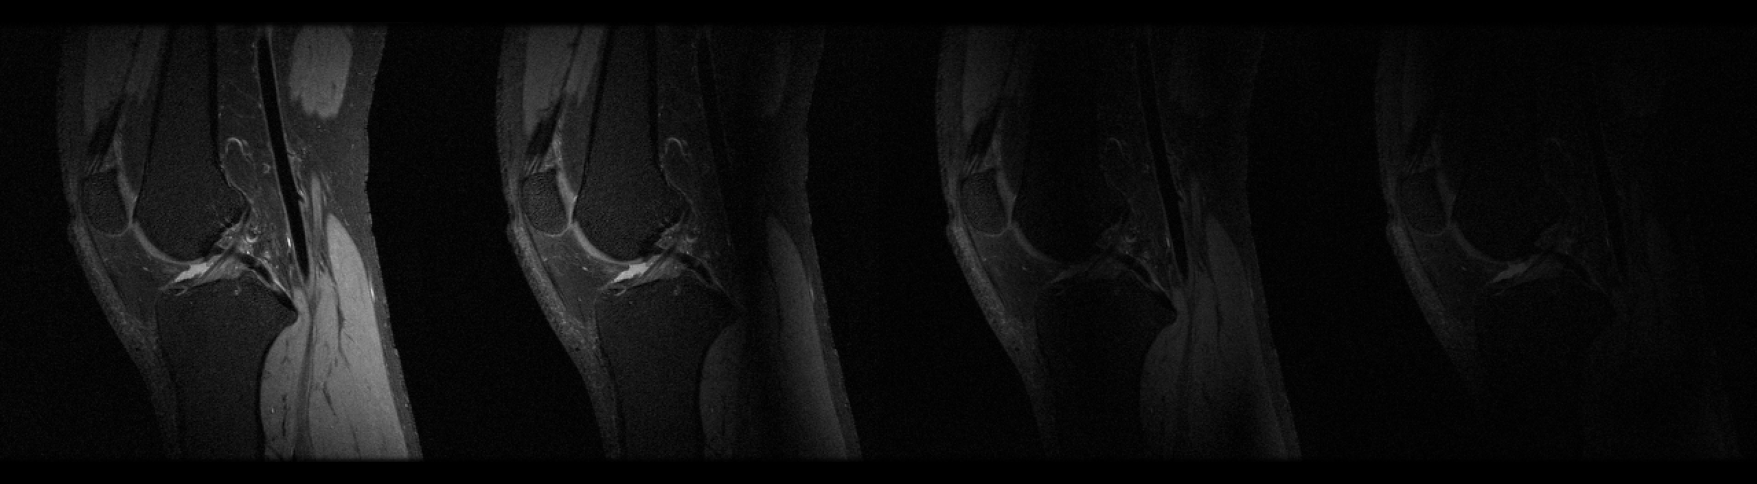

/Users/malits/anaconda3/envs/bart/lib/python3.7/site-packages/traitlets/traitlets.py:567: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


AppLayout(children=(VBox(children=(RadioButtons(description='Up/Down', options=('Dim 0', 'Dim 1'), value='Dim …

In [34]:
BartViewWidget("knee_cc_flat")

We can consolidate this process into a bash function that generalizes to arbitrary slice dimensions and number  of coils. 

Usage: `flatten <data> <output>`

In [ ]:
%%bash
function flatten(){
    # The flattened image's dimensions are calculated as (num coils) * (slice dims)
    # get the slice dimensions and number of coils
    let slice_dim=$(bart show -d 1 $1)
    let coils=$(bart show -d 3 $1)
    
    let "flat_dim = slice_dim * coils"
    
    bart reshape $(bart bitmask 1 3) $flat_dim 1 $1 $2
}

Now let's look at our uncompressed FFT data, across eight coils.

In [35]:
!flatten knee_uncompressed slice_flat

/bin/sh: flatten: command not found


<IPython.core.display.Javascript object>


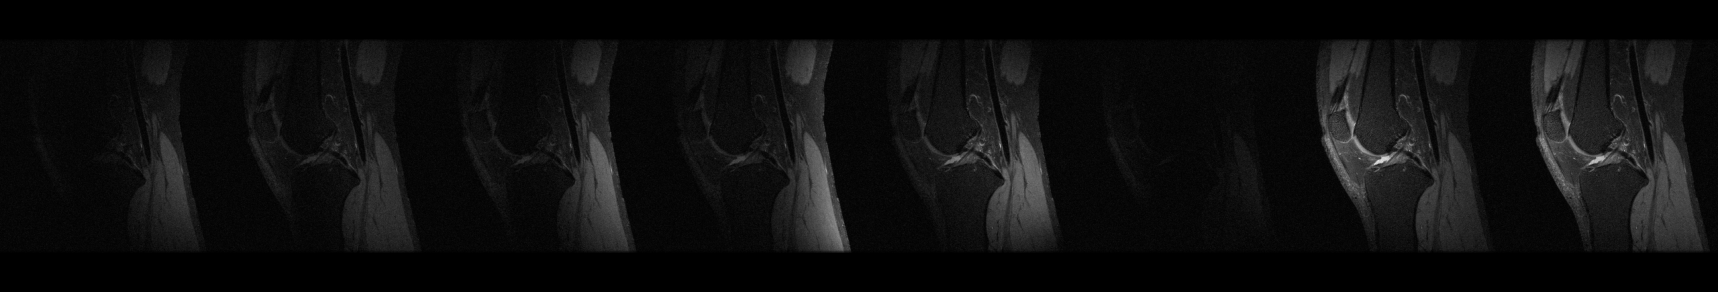

AppLayout(children=(VBox(children=(RadioButtons(description='Up/Down', options=('Dim 0', 'Dim 1'), value='Dim …

In [36]:
BartViewWidget("slice_flat")

Compare the differing sensitivities to observe the effect of compression to four virtual coils. Double-click the images to enlarge.

### Combining Multi-Coil Images

Let's combine the compressed images via a Root Sum-Of-Squares (`rss`) message. 

In [ ]:
%%bash
bart rss -h

In [ ]:
%%bash
bart rss $(bart bitmask 3) knee_cc knee

In [ ]:
%%bash
imshow knee

## Scripting the Pipeline

Finally, we will consolidate the basic tools above into a Bash script that automates this reconstruction with detailed output at each step. We'll then show how this function makes it easy to reconstruct each slice of our 3D data.

USAGE: `slice_recon <data> <slice>`

In [ ]:
%%bash
bart slice -h

In [ ]:
%%bash
function slice_recon() {
    
    echo "[INFO] Performing inverse FFT along the readout direction..."
    bart fft -i -u $(bart bitmask 2) $1 readout_fft
    
    echo "[INFO] Extracting slice..."
    bart slice 2 $1 readout_fft slice
    
    echo "[INFO] Performing coil compression on the slice..."
    bart cc -p 4 -G slice slice_cc
    
    echo "[INFO] Performing FFT on the image..."
    bart fft -i -u $(bart bitmask 0 1) slice_cc slice_fft
    
    echo "[INFO] Combining coil compressed images..."
    bart rss $(bart bitmask 3) slice_fft final

}